In [194]:
import json
import pandas as pd
import os
from datetime import datetime, timedelta
import getActivities
import folium
from folium import plugins
import decoder
import matplotlib.pyplot as plt

#if file doesn't exist make requests for new activities


#getActivities.getLastest()
#else if file hasn't been updated in 12 hours
    #make new request
if not os.path.exists("myActivities.json"):
    getActivities.getLastest()
    print("Getting latest activities")
elif os.path.getctime("myActivities.json"):
    #If activites json is over 12 hours old update
    getActivities.getLastest()

with open("myActivities.json") as activities:
    data = json.load(activities)

In [153]:
map = folium.Map(location=[40.8923, -74.4774], zoom_start=10) #intialize the map


lines = []
#Get all the polyline routes for each activity and decode them 
for activity in data:
    encodedLine = activity['map']['summary_polyline']
    if encodedLine != None:
        decoded = decoder.decode_polyline(activity['map']['summary_polyline']) #decode the line
        folium.PolyLine(decoded).add_to(map) #add the line to the mao

map.save('./map.html')


Text(0.5, 1.0, 'Distance (miles) per month')

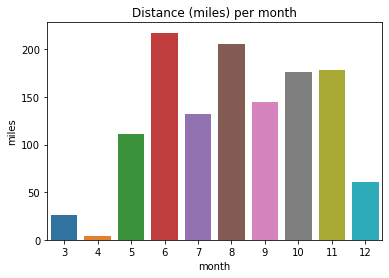

In [150]:
from datetime import datetime
import seaborn as sns

df = pd.json_normalize(data)


rides = df.loc[df['type'] == 'Ride']

rides['start_date'] = pd.to_datetime(rides['start_date'], format="%Y-%m-%dT%H:%M:%SZ")
rides['month'] = pd.DatetimeIndex(rides['start_date']).month

def metersToMiles(meters):
    km = meters / 1000
    miles = km / 1.609344
    return miles

rides['miles'] = rides['distance'].apply(lambda x: metersToMiles(x))
byMonth = rides.groupby('month')['miles'].sum()

ax = sns.barplot(x=byMonth.index, y=byMonth)
ax.set_title("Distance (miles) per month")



In [151]:
def minutesToMPH(minutes):
    kmh = 60/minutes
    mph = kmh / 1.609344
    return mph

rides['average_speed'] = rides['average_speed'].apply(lambda x: minutesToMPH(x)) #convert minutes per kilometer to miles per hour

print(rides['average_speed'])

def metersToFeet(meters):
    feet = meters * 3.28084
    return feet

rides['total_elevation_gain'] = rides['total_elevation_gain'].apply(lambda x: metersToFeet(x))

rides['gear_id'] = rides['gear_id'].fillna('b7323503') #fill na values with road bike

print(rides[['miles', 'gear_id']])



0       5.940451
1      16.569898
2       5.936667
6      11.599960
7       9.246595
         ...    
96     14.918876
103     6.209572
112     7.219650
115     6.162359
117     7.106800
Name: average_speed, Length: 62, dtype: float64
         miles   gear_id
0    10.163209  b7323503
1    10.377085  b8356085
2    17.211920  b7323503
6    12.597307  b8356085
7    10.225284  b7323503
..         ...       ...
96    7.827661  b8356085
103  23.178388  b7323503
112   4.011262  b7323503
115  10.048939  b7323503
117  16.139495  b7323503

[62 rows x 2 columns]


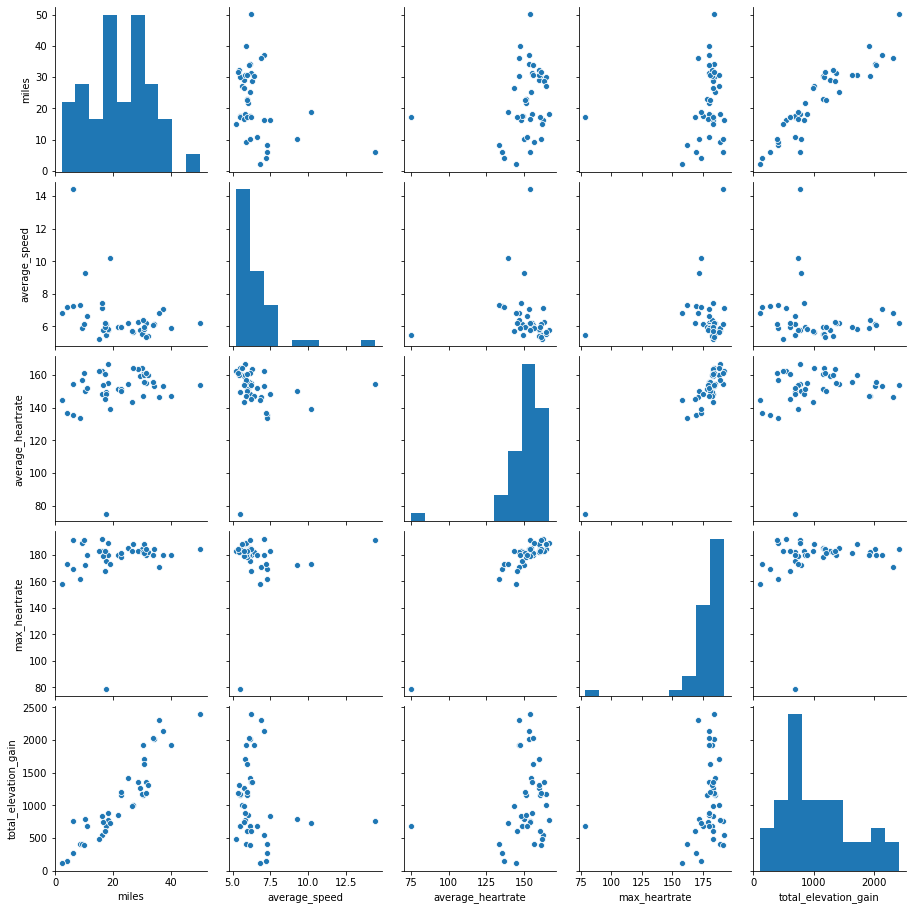

In [170]:
import tensorflow as tf
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

filtered = rides.loc[rides['gear_id'] == 'b7323503'] #Filter out road rides
filtered = filtered.drop(columns = rides.columns.difference(['miles', 'average_speed', 'average_heartrate', 'max_heartrate', 'total_elevation_gain']))

#get training and test sets
train = filtered.sample(frac=0.8, random_state=0)
test = filtered.drop(train.index)

sns.pairplot(train[['miles', 'average_speed', 'average_heartrate', 'max_heartrate', 'total_elevation_gain']])

In [162]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train)) #normalize the features


[1063.9764      6.501219  151.28604   178.06976    22.220041]


In [166]:
#One variable regression gain vs. distances

train_results = train.pop('miles')
test_results = test.pop('miles')

gain = np.array(train['total_elevation_gain'])

gain_normalizer = preprocessing.Normalization()
gain_normalizer.adapt(gain)

#Defining the model
gain_model = tf.keras.Sequential([
    gain_normalizer,
    layers.Dense(units=1)
])

gain_model.summary()

gain_model.predict(gain[:10])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_9 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


array([[-0.4315341 ],
       [-0.24849197],
       [ 0.8834363 ],
       [-0.6520538 ],
       [ 0.29927665],
       [-0.22812377],
       [-0.19227576],
       [ 0.7883848 ],
       [ 0.07631277],
       [ 0.16240236]], dtype=float32)

In [171]:
#compile the model and set loos and optimization functions
gain_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [173]:
#running the model
history = gain_model.fit(
    train['total_elevation_gain'], train_results,
    epochs=100,
    #verbose=0Dont log
    validation_split=0.2 #use 20 percent of data for validation
)

Epoch 1/100
2/2 [==============================] - 0s 18ms/step - loss: 4.9059 - val_loss: 7.0003
Epoch 2/100
2/2 [==============================] - 0s 6ms/step - loss: 4.7622 - val_loss: 6.8750
Epoch 3/100
2/2 [==============================] - 0s 6ms/step - loss: 4.6175 - val_loss: 6.7355
Epoch 4/100
2/2 [==============================] - 0s 6ms/step - loss: 4.4687 - val_loss: 6.5886
Epoch 5/100
2/2 [==============================] - 0s 6ms/step - loss: 4.3340 - val_loss: 6.4512
Epoch 6/100
2/2 [==============================] - 0s 6ms/step - loss: 4.2210 - val_loss: 6.3177
Epoch 7/100
2/2 [==============================] - 0s 6ms/step - loss: 4.1144 - val_loss: 6.1892
Epoch 8/100
2/2 [==============================] - 0s 6ms/step - loss: 4.0086 - val_loss: 6.0701
Epoch 9/100
2/2 [==============================] - 0s 6ms/step - loss: 3.9111 - val_loss: 5.9557
Epoch 10/100
2/2 [==============================] - 0s 7ms/step - loss: 3.8252 - val_loss: 5.8489
Epoch 11/100
2/2 [==========

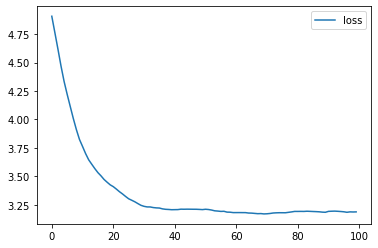

In [178]:
#Plotting loss vs epochs
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

plt.plot(history.history['loss'], label='loss')
plt.legend()

In [182]:
#Testing model to test set
predicted = gain_model.evaluate(
    test['total_elevation_gain'],
    test_results
)


1/1 [==============================] - 0s 997us/step - loss: 4.0740


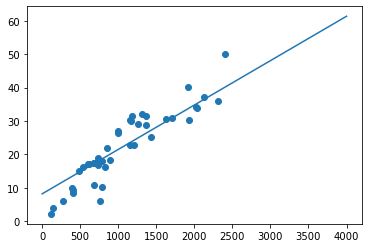

In [189]:
x = np.linspace(0, 4000, num=250) #Make random elevations
y = gain_model.predict(x) #predict distance

plt.scatter(train['total_elevation_gain'], train_results)
plt.plot(x, y)

